<a href="https://colab.research.google.com/github/Vaggelis-Arg/Amazon-Ecommerce-Analysis/blob/main/Amazon_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Τεχνικές Εξόρυξης Δεδομένων (2024-2025)

## Ομάδα & Παραδοχές

### Team Information

#### Team member #1: [**Vaggelis-Arg**](https://github.com/Vaggelis-Arg)
* Ονοματεπώνυμο: Βαγγέλης Αργυρόπουλος
* Αριθμός Μητρώου: sdi2200010
* email: sdi2200010@di.uoa.gr
---
#### Team member #2: [**chrisvl11**](https://github.com/chrisvl11)
* Ονοματεπώνυμο: Χρήστος Βλαδίκας
* Αριθμός Μητρώου: sdi2200020
* email: sdi2200020@di.uoa.gr
---
#### Team member #3: [**tonykalantzis**](https://github.com/tonykalantzis)
* Ονοματεπώνυμο: Αντώνιος Παναγιώτης Καλαντζής
* Αριθμός Μητρώου: sdi2100046
* email: sdi2100046@di.uoa.gr
---

### Παραδοχές

## Set up of the notebook

### Downloads

In [1]:
!pip install nltk
!pip install datasets
!pip install contractions
!pip install matplotlib seaborn wordcloud

### Imports

In [2]:
import nltk
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet'])
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
import pandas as pd
import re
import string
import contractions
from datasets import load_dataset


[nltk_data] Downloading package punkt to /home/tony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tony/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/tony/Code/DIT/YS11-Data-Extraction-Techniques/Amazon-Ecommerce-Analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1 - Pre-processing

### Task 1: Data Exploration and Feature Engineering

#### Dataset Preparation

We used the `datasets` library from Hugging Face to stream and extract reviews and metadata for selected Amazon product categories. For demonstration, we focused on the "All_Beauty" category.

The dataset includes product reviews, ratings, and associated metadata. After loading, the data was saved as CSV files (`*_reviews_raw.csv` and `*_metadata_raw.csv`) to simplify further processing.

We ensure the CSVs contain essential fields like `rating`, `text`, `parent_asin`, and product details for later analysis.



In [6]:
# Configs: (category_name, review_config, meta_config)
datasets_info = [
    # ("Books", "raw_review_Books", "raw_meta_Books"),
    ("All_Beauty", "raw_review_All_Beauty", "raw_meta_All_Beauty"),
    # ("Electronics", "raw_review_Electronics", "raw_meta_Electronics"),
    # ("Movies_and_TV", "raw_review_Movies_and_TV", "raw_meta_Movies_and_TV"),
    # ("Sports_and_Outdoors", "raw_review_Sports_and_Outdoors", "raw_meta_Sports_and_Outdoors"),
]
    
# Select correct columns 
review_columns = [
    "rating", "title", "text", "parent_asin", "user_id", "timestamp", 
    "helpful_vote", "verified_purchase"
]
meta_columns = [
    "parent_asin", "main_category", "title", "average_rating", "rating_number",
    "description", "price", "categories", "bought_together"
]

for category, review_config, metadata_config in datasets_info:
    print(f"Loading (streaming): {category}")

    # Load streaming datasets with limited columns
    reviews_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        review_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(review_columns)

    metadata_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        metadata_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(meta_columns)

    # Convert to pandas and save (batching to avoid RAM overload)
    reviews_df = pd.DataFrame(reviews_iter.take(100_000))  # adjust as needed
    metadata_df = pd.DataFrame(metadata_iter.take(100_000))  # adjust as needed

    reviews_df.to_csv(f"{category}_reviews_selected.csv", index=False)
    metadata_df.to_csv(f"{category}_metadata_selected.csv", index=False)

    print(f"Saved selected columns for {category}")
    

Loading (streaming): All_Beauty
Saved selected columns for All_Beauty


#### Text Preprocessing

Text fields like `title` and `review text` were cleaned using a custom preprocessing function that includes:

- Lowercasing
- URL, mention, hashtag, and email removal
- Contraction expansion (`don't` → `do not`)
- Emoticon normalization (e.g., `:)` → `happy`)
- Removal of punctuation, numbers, and excessive character repetitions

These cleaned fields (`cleaned_title`, `cleaned_text`) are used for visualizations and later analysis tasks.


In [8]:
# Emoticon dictionary for replacements
emoticons = {
    ":)": "happy",
    ":-)": "happy",
    ":(": "sad",
    ":-(": "sad",
    ":D": "happy",
    ":-D": "happy",
    ";)": "wink",
    ";-)": "wink"
}

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"\S+@\S+", '', text)  # remove emails
    text = contractions.fix(text)  # expand contractions

    # Replace emoticons
    for emoticon, word in emoticons.items():
        text = text.replace(emoticon, word)

    text = re.sub(r"[" + string.punctuation + "]", '', text)  # remove punctuation
    text = re.sub(r"\d+", '', text)  # remove numbers
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # reduce 3+ char repeats to 2

    text = text.strip()
    return text

# Load and clean each dataset
for category, *_ in datasets_info:
    print(f"Processing: {category}")
    reviews = pd.read_csv(f"{category}_reviews_selected.csv")
    metadata = pd.read_csv(f"{category}_metadata_selected.csv")

    reviews = reviews.dropna(subset=["rating", "text", "parent_asin"])
    reviews["cleaned_title"] = reviews["title"].apply(preprocess_text)
    reviews["cleaned_text"] = reviews["text"].apply(preprocess_text)
    reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit="ms")

    df = pd.merge(reviews, metadata, on="parent_asin", how="left", suffixes=("", "_meta"))
    df.to_csv(f"{category}_cleaned.csv", index=False)
    print(f"Saved cleaned data to {category}_cleaned.csv")

print(reviews.head())

Processing: All_Beauty
Saved cleaned data to All_Beauty_cleaned.csv
   rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text parent_asin  \
0  This spray is really nice. It smells really go...  B00YQ6X8EO   
1  This product does what I need it to do, I just...  B081TJ8YS3   
2                          Smells good, feels great!  B097R46CSY   
3                                     Felt synthetic  B09JS339BZ   
4                                            Love it  B08BZ63GMJ   

                        user_id               timestamp  helpful_vote  \
0  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-05 14:08:48.923             0   
1  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-

#### Review Ratings and Trends

We performed exploratory data analysis on the cleaned dataset, including:

- **Rating distribution** histograms to understand the spread of reviews across 1–5 stars.
- **Word cloud visualizations** for low-rated yet popular products, highlighting commonly used words in negative reviews.
- **Top 5 best-selling products** based on review count, with metadata summaries printed for each.
- **Monthly rating trends** using line plots to observe how customer sentiment evolved over time.

These visual insights help identify patterns, seasonality, and quality issues across products.


Visualizing: All_Beauty


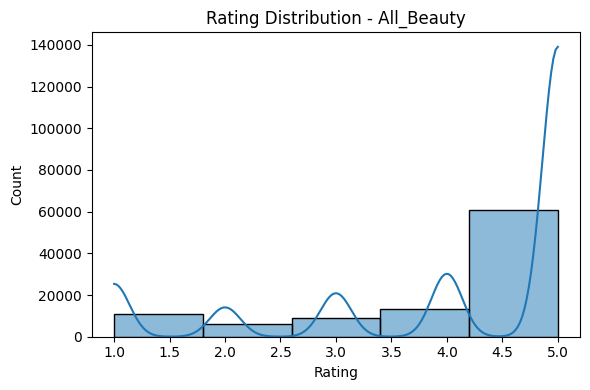

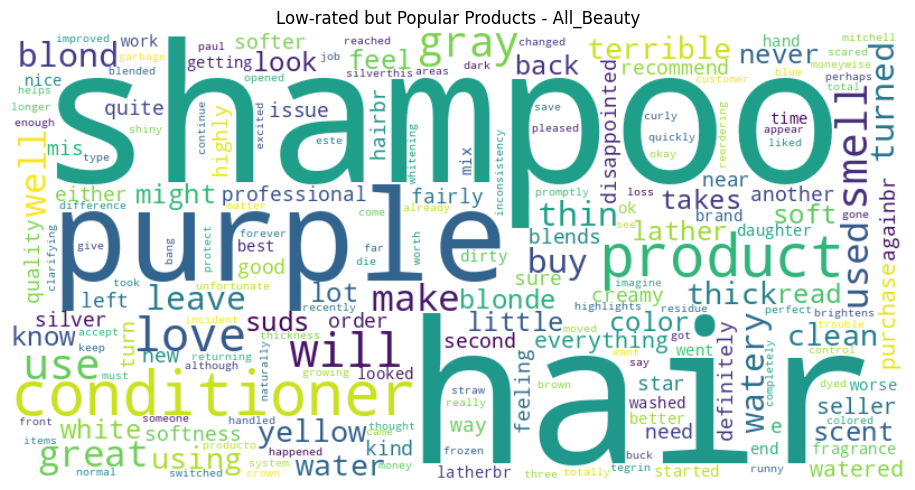


Top 5 Best-Selling Products in All_Beauty:

Title: Salux Nylon Japanese Beauty Skin Bath Wash Cloth/towel (3) Blue Yellow and Pink
ASIN: B085BB7B1M
Store: Unknown
Features: []
Avg Rating: 4.62
Total Reviews: 328
------------------------------------------------------------
Title: Godefroy Tint Kit for Spot Coloring, Dark Brown
ASIN: B0BM4GX6TT
Store: Unknown
Features: []
Avg Rating: 4.19
Total Reviews: 246
------------------------------------------------------------
Title: GranNaturals Boar Bristle Smoothing Hair Brush for Women and Men - Medium/Soft Bristles - Natural Wooden Large Flat Square Paddle Hairbrush for Fine, Thin, Straight, Long, or Short Hair
ASIN: B00R1TAN7I
Store: Unknown
Features: []
Avg Rating: 3.80
Total Reviews: 216
------------------------------------------------------------
Title: Harlorki Women's Bohemian Jewelry Statement Necklaces Women Rhinestone Gem Pendant Collar
ASIN: B0107QYW14
Store: Unknown
Features: []
Avg Rating: 4.02
Total Reviews: 209
----------------

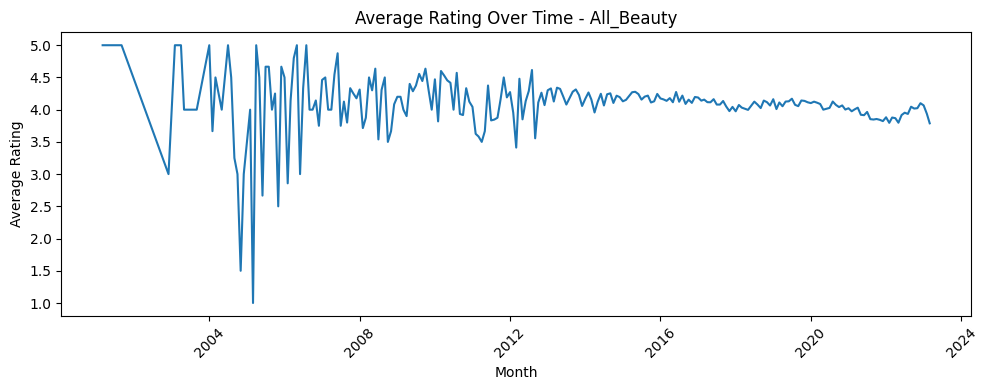

In [9]:
for category, *_ in datasets_info:
    print(f"Visualizing: {category}")
    df = pd.read_csv(f"{category}_cleaned.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])  # Ensure datetime
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()

    # --- Rating Distribution ---
    plt.figure(figsize=(6, 4))
    sns.histplot(df["rating"], bins=5, kde=True)
    plt.title(f"Rating Distribution - {category}")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Low-rated Popular Products ---
    stats = df.groupby("parent_asin").agg(avg_rating=("rating", "mean"), count=("rating", "count")).reset_index()
    bad_asins = stats[(stats["count"] > 50) & (stats["avg_rating"] < 3.0)]["parent_asin"]
    bad_text = " ".join(df[df["parent_asin"].isin(bad_asins)]["cleaned_text"].dropna())

    if bad_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(bad_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Low-rated but Popular Products - {category}")
        plt.tight_layout()
        plt.show()

    # --- Top 5 Best-Selling Products ---
    top5 = df["parent_asin"].value_counts().head(5).index
    print(f"\nTop 5 Best-Selling Products in {category}:\n")
    for asin in top5:
        item = df[df["parent_asin"] == asin].iloc[0]
        print(f"Title: {item.get('title_meta', 'N/A')}")
        print(f"ASIN: {asin}")
        print(f"Store: {item.get('store', 'Unknown')}")
        print(f"Features: {item.get('features', [])}")
        print(f"Avg Rating: {df[df['parent_asin'] == asin]['rating'].mean():.2f}")
        print(f"Total Reviews: {len(df[df['parent_asin'] == asin])}")
        print("-" * 60)

    # --- Trend Line ---
    trend = df.groupby("month")["rating"].mean().reset_index()
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trend, x="month", y="rating")
    plt.xticks(rotation=45)
    plt.title(f"Average Rating Over Time - {category}")
    plt.xlabel("Month")
    plt.ylabel("Average Rating")
    plt.tight_layout()
    plt.show()


### Task 2: Feature Engineering with **Sentiment Scores** and Ratings

Ιδεα αυτοματοποιησης
```python
class Sentiment_Score_and_Ratig
    sentiment extractor = {
        Vader
        DistilBERT
        RoBERTa
        BERT
    }

    sentiment_score_weighted_text_rating(w0, w1, sentiment_exctractor )


    sentiment_score_rating_adjusted
```

#### Alternative 1: Weighted Combination of Text Sentiment and Rating  

### Task 3: Feature Engineering with Price Metrics (Optional)

## Part 2 - Learning Tasks